![HenryLogo](https://d31uz8lwfmyn8g.cloudfront.net/Assets/logo-henry-white-lg.png)

# **Proyecto integrador**

### 3. Modelamiento

Una vez preparados los datos, se procederá con el modelamiento. Recuerden que el objetivo es clasificar a un paciente como hospitalizado o no hospitalizado, teniendo en cuenta un data set que contiene información referente a antecedentes del paciente, morbilidad asociada al paciente y antecedentes relacionados con la toma de la biopsia y complicaciones infecciosas.




Carguen la base de datos preparada desde la fase 2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [2]:
df_hospitalizacion = pd.read_csv(r'.\Datasets\BDHospitalizacion.csv')

Separen el dataset en X, y (variable objetivo)

In [3]:
y = df_hospitalizacion["hospitalizacion"]
X = df_hospitalizacion.drop("hospitalizacion", axis=1)

In [4]:
# Verifiquemos la dimension de los datos
print(f'En X : {X.shape}, ahora en y :{y.shape}') 

En X : (568, 24), ahora en y :(568,)


In [5]:
# Ahora observemos el balanceo de las clases en y
clases = pd.value_counts(y,sort=True)
print(f'Las clases se encuentran en las siguientes proporciones para la variable : {clases}')

Las clases se encuentran en las siguientes proporciones para la variable : hospitalizacion
0    544
1     24
Name: count, dtype: int64


In [6]:
if clases[0] < clases[1]:
    tasa = round(clases[0] / (clases[0] + clases[1]) * 100,2)
    mensaje = f'La clase "NO" representa un {tasa}% del total de muestras'
elif clases[1] < clases[0]:
    tasa = round(clases[1] / (clases[0] + clases[1]) * 100,2)
    mensaje = f'La clase "SI" representa un {tasa}% del total de muestras'
else :
    print('Verificar ...')
print(mensaje)

La clase "SI" representa un 4.23% del total de muestras


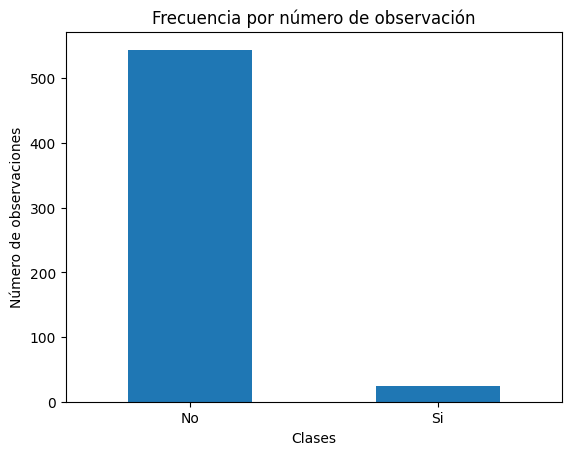

In [7]:
# Visualizemos la proporcion de las clases
count_classes = pd.value_counts(y, sort = True)
count_classes.plot(kind ='bar', rot=0)
plt.xticks(range(2), labels=['No','Si'])
plt.title("Frecuencia por número de observación")
plt.xlabel("Clases")
plt.ylabel("Número de observaciones");


 Notemos que existe un desbalance, en un primer intento busquemos equilibrar a la clase minoritaria,  penalizando a la clase mayoritaria durante el entrenamiento. Ejemplo ajustando el peso en árboles, o también en regresion logistica que contamos con el parametro **class_weight= «balanced»**.

Separen el dataset en X_train, X_test, y_train y y_test

In [8]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=19) # Dividimos el dataset en entrenamiento y test
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(369, 24) (369,)
(199, 24) (199,)


Instancien, entrenen y predigan sobre un árbol de decisión asignando una profundidad máxima arbitraria

In [9]:
# Entrenemos nuestro modelo sin utilizar ninguna estrategia de correccion de balanceo
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(class_weight={1:22.7}, # Para el valor de class_weight, el 1 es la etiqueta Si, y el 22.7 sale de el total de No entre el total de Si = 544/24 = 22.7
                             criterion = 'gini', 
                             random_state = 40,
                             max_depth = 4) # Crear un clasificador

clf.fit(X_train, y_train) # Entrene el modelo de clasificación de árbol de decisión en el conjunto de entrenamiento.# Entrenamos
y_pred = clf.predict(X_test) # predicciones de los datos de prueba X_test con el modelo entrenado


Realicen la matriz de confusión para este modelo. Se recomienda utilizar mapa de calor para la visualización. 

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[182   9]
 [  0   8]]


0.9547738693467337

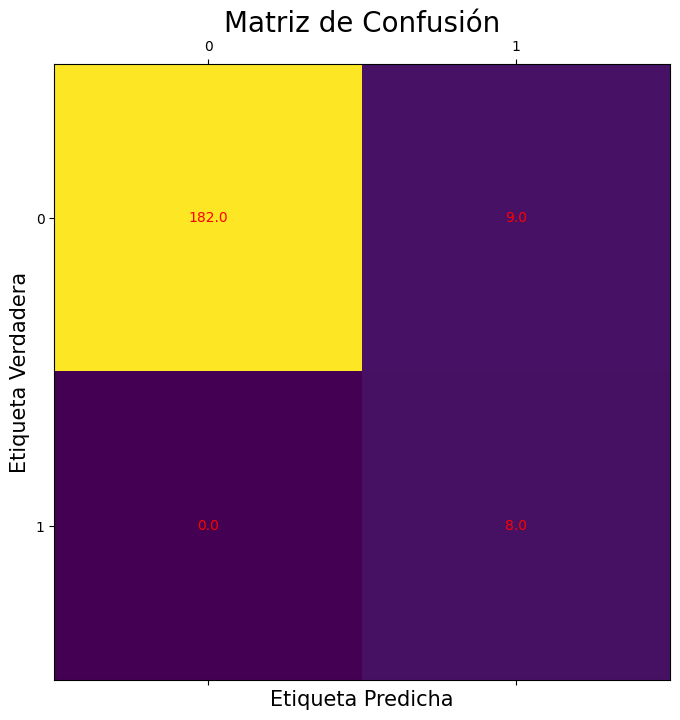

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color= 'red')

Seleccione tres métricas de evaluación para este modelo de clasificación y describa el significado de cada una de ellas para el modelo creado.

In [12]:
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", round(accuracy,2))
recall = recall_score(y_test, y_pred)
print("Recall:", round(recall,2))
f1 = f1_score(y_test, y_pred)
print("F1-Score:", round(f1,2))

Precisión: 0.95
Recall: 1.0
F1-Score: 0.64


Estamos frente a un problema donde existe un desbalanceo en los datos, por tanto :
**Precision** no me va ayudar de mucho, esta metrica aportaria mucho si las cantidades de ambas clases fuesen similares.
**Recall** me esta indicano que no estoy perdiendo positivos.
**F1 Score** No es muy aceptable 
   

Realice un diagrama de la importancia de cada variable respecto a la clasificación de la variable objetivo

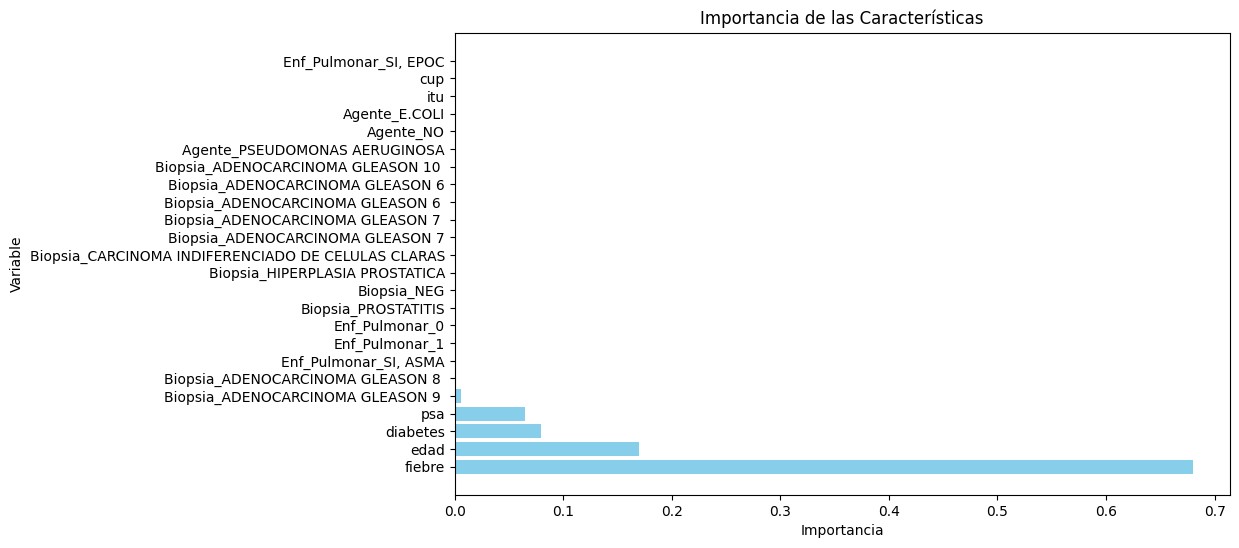

In [13]:
importances = clf.feature_importances_

variables = X.columns

df = pd.DataFrame({'Variable': variables, 'Importancia': importances})

df = df.sort_values('Importancia', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(df['Variable'], df['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de las Características')
plt.show() 

Encuentre cuál sería un valor óptimo para el hiperparámetro **max_depth** para el árbol de decisión. Construya un modelo con este valor y compare las métricas de evaluación respecto al modelo creado con una profundidad arbitraria. 

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'max_depth': randint(low=8,high=50)
    }

clf = DecisionTreeClassifier(class_weight={1:22.7}, # Para el valor de class_weight, el 1 es la etiqueta Si, y el 22.7 sale de el total de No entre el total de Si = 544/24 = 22.7
                             criterion = 'gini', 
                             random_state = 40)

busqueda_vc = RandomizedSearchCV(clf, param_distributions = param_distribs, n_iter=8, cv=3, scoring='r2')
busqueda_vc.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight={1: 22.7},
                                                    random_state=40),
                   n_iter=8,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029429244920>},
                   scoring='r2')

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[182   9]
 [  0   8]]


0.9547738693467337

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", round(accuracy,2))
recall = recall_score(y_test, y_pred)
print("Recall:", round(recall,2))
f1 = f1_score(y_test, y_pred)
print("F1-Score:", round(f1,2))

Precisión: 0.95
Recall: 1.0
F1-Score: 0.64


No existe mucha diferencia, se debe continuar buscando otros parametros

Instancien, entrenen y predigan sobre un modelo de k-vecinos asignando una cantidad de vecinos k-aribitraria. 

In [17]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2) # p es el parámetro de la distancia de Minkowski 
                                                                                #(p = 2 es la distancia euclidiana, p=1 es la distancia de Manhattan)
                                                                                #metric = 'minkowski' es la distancia de Minkowski
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [18]:
y_pred = classifier.predict(X_test) # predecir los valores de X_test con el modelo entrenado (classifier)

Encuentre el valor óptimo para k

([<matplotlib.axis.XTick at 0x294293555e0>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18'),
  Text(20, 0, '20')])

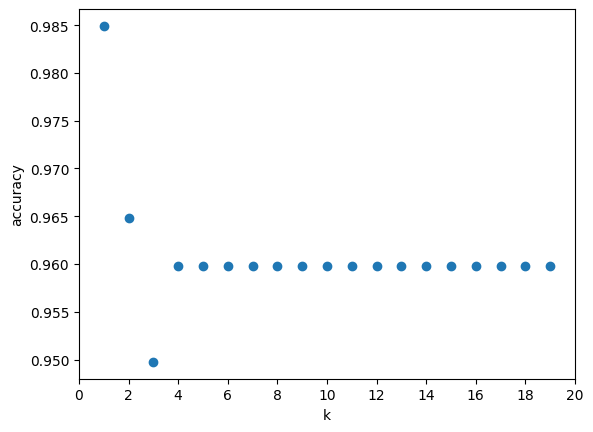

In [19]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,2,4,6,8,10,12,14,16,18,20])

Halle las mismas tres métricas de evaluación para este modelo de clasificación y compare los valores para el performance, respecto al árbol de decisión cuyo hiperparámetro **max_depth** se optimizó. ¿Qué puede concluir? 

In [21]:
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", round(accuracy,2))
recall = recall_score(y_test, y_pred)
print("Recall:", round(recall,2))
f1 = f1_score(y_test, y_pred)
print("F1-Score:", round(f1,2))

Precisión: 0.96
Recall: 0.0
F1-Score: 0.0


De acuerdo con lo aprendido en el módulo, ¿Cómo cree que se puede mejorar el performance de este modelo?

Para encontrar el mejor modelo, se requiere de un conjunto de pruebas, entonces para un modelo escogido especificamente se requiere experimentar con distintos valores de sus parámetros, con el propósito de encontrar la configuración que optimice el rendimiento.